<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/accent-tf2/src

/content/drive/My Drive/Colab Notebooks/accent-tf2/src


### Import packages

In [3]:
import re, zipfile, os, io, time, string, numpy as np, matplotlib.ticker as ticker, \
            matplotlib.pyplot as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# from utils import process_raw, generate_input, get_max_len, process_data, convert

from token_list import strip_tokens
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TensorFlow 2.x selected.


In [0]:
# x = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH se den han trong 2 ngay toi. So tien  2.999.898 VND, TK 12345678912. Bo qua neu da TT. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH da qua han 1 ngay. TK 12345678912, so tien2.999.898 VND. Bo qua neu da TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 6 ngay va bi tinh phat 250,000. TK 12345678912, so tien 2.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'KH da qua han 5 ky no. TK 12345678912, so tien 12.999.898VND. Vui long TT ngay lap tuc. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da bi tinh phat do lien tuc vi pham. TK12345678912, so tien 12.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 91 ngay. Vui long TT toan bo29.999.898VND vao TK 12345678912 hom nay. Thong tin chi tiet, lien he 18006288',
# 'Chung toi vua nhan thanh toan khoan vay cua KH tu TK12345678912. TUY NHIEN, KH van con thieu 29.999.898VND. Vui long TT toan ngay lap tuc. Cam on']

### Custom functions

In [0]:
def process_raw(raw_data):
    raw_data = [seq.lower().strip() for seq in raw_data]

    # Creating a space between a word and the punctuation following it
    # Eg: "he is a boy." => "he is a boy ."
    raw_data = [re.sub(r"([?.!,¿])", r" \1 ", seq) for seq in raw_data]
    raw_data = [re.sub(r'[" "]+', " ", seq) for seq in raw_data]

    # Replacing everything with space except (characters, ".", "?", "!", ",")
    filtered_punctuations = string.punctuation
    exclude = [',', '!', '.', '?']

    for c in filtered_punctuations:
        if c in exclude:
            filtered_punctuations = filtered_punctuations.replace(c, '')

    table = str.maketrans('', '', filtered_punctuations)
    raw_data = [seq.translate(table) for seq in raw_data]
    
    # Append start and end tokens to sequences
    processed_raw = []
    for seq in raw_data:
        words = seq.split()
        words = [word.strip() for word in words]
        processed_raw.append(' '.join(words))

    # processed_raw = ['<s> ' + seq + ' <e>' for seq in processed_raw]
    processed_raw = ['<s> ' + seq + ' <e>' for seq in processed_raw]

    return processed_raw

In [0]:
def generate_input(processed_raw):
    output = ''
    for char in processed_raw:
        if char in strip_tokens:
            output += strip_tokens[char]
        else:
            output += char          
    return output

In [0]:
def get_max_len(input_data, get_index=False): 
    longest = [len(data.split()) for data in input_data]
    if get_index:
        print(longest.index(max(longest)))
    return max(longest)

In [0]:
def tokenize_pad_data(data, pad_len=None):
    tk = Tokenizer(char_level=False, filters='')
    tk.fit_on_texts(data)
    data = tk.texts_to_sequences(data)
    data = pad_sequences(data, padding='post', maxlen=pad_len)
    return data, tk

In [0]:
def process_data(processed_input, processed_target, pad_len=None):    
    tokenized_input, input_tokenizer = tokenize_pad_data(data=processed_input, pad_len=pad_len)
    tokenized_target, target_tokenizer = tokenize_pad_data(data=processed_target, pad_len=pad_len)
    return tokenized_input, input_tokenizer, tokenized_target, target_tokenizer

In [0]:
def convert(tokenizer, tokenized_data, send_back=False):
    original = []
    
    print('Tokenized Data: {}'.format(tokenized_data))
    print('\n')
    
    for token in tokenized_data:
        if token != 0:
            if token in tokenizer.index_word:
                original.append(tokenizer.index_word[token])
            else:
                original.append('<unk>')
                    
    print('Original Data: {}'.format(original))
    
    if send_back:
        return original

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_process_seq, max_process_seq))

#     sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_process_seq, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']], 0)

    for t in range(max_process_seq):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<e>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
      
    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def restore(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Environment variables

In [14]:
# Define data arguements
# Set random seed
np.random.seed(50)
data_file = '../data/raw/raw_train.txt'

tf.__version__

'2.0.0-rc0'

### Load and process dataset

In [0]:
# Load dataset
counter = 0
max_seq_len = 40
no_seq = 100000
raw_data = []

# Load raw data and read first 100000 sequences with 40 or less words
with open(data_file, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            continue

In [16]:
# Process dataset
# From the 1000000 sequences, randomly pick 20000
random_pick = 50000
random_idx = np.random.choice(no_seq, random_pick, replace=False)
raw_data = [raw_data[i] for i in random_idx]

# Shuffle raw data prior to processing
np.random.shuffle(raw_data)

# Process raw and input data
filtered_raw = process_raw(raw_data)
processed_inp = [generate_input(seq) for seq in filtered_raw]

# Get max sequence length after processing
max_process_seq = get_max_len(processed_inp, get_index=False)
print('Max input sequence length: {}'.format(get_max_len(processed_inp)))
print('Max target sequence length: {}'.format(get_max_len(filtered_raw)))

Max input sequence length: 54
Max target sequence length: 54


In [17]:
print('Input Sample:')
print(processed_inp[-1])
print('\n')
print('Target Sample:')
print(filtered_raw[-1])

Input Sample:
<s> trong sach hieu kinh co ghi khue chu van chuong . <e>


Target Sample:
<s> trong sách hiếu kinh có ghi khuê chủ văn chương . <e>


In [0]:
# Tokenize/pad input and target data, generates corresponding tokenizers
tokenized_input, input_tokenizer, tokenized_target, target_tokenizer = process_data(processed_input=processed_inp, 
                                                            processed_target=filtered_raw, pad_len=max_process_seq)

In [19]:
train_data_len = round((.8 * random_pick))
val_test_data_len = round((.1 * random_pick))

train_inp_data, train_tar_data = tokenized_input[:train_data_len], tokenized_target[:train_data_len]
val_inp_data, val_tar_data = tokenized_input[train_data_len:(train_data_len+val_test_data_len)], \
                                    tokenized_target[train_data_len:(train_data_len+val_test_data_len)]
test_inp_data, test_tar_data = tokenized_input[-val_test_data_len:], tokenized_target[-val_test_data_len:]

print('Number of training sequences: {}'.format(len(train_inp_data)))
print('Number of val sequences: {}'.format(len(val_inp_data)))
print('Number of test sequences: {}'.format(len(test_inp_data)))

Number of training sequences: 40000
Number of val sequences: 5000
Number of test sequences: 5000


In [20]:
convert(input_tokenizer, train_inp_data[0])

Tokenized Data: [   2   51   49   58 1586  323  433  253  275   47   42   18    7  398
  183    1    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


Original Data: ['<s>', 'van', 'thu', 'nhat', 'kasparov', 'tung', 'buoc', 'don', 'may', 'tinh', 'vao', 'the', 'co', 'thua', 'cuoc', '.', '<e>']


In [0]:
train_buffer_sz = len(train_inp_data)
val_buffer_sz = len(val_inp_data)
batch_sz = 64

train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_data, train_tar_data)).shuffle(train_buffer_sz)
train_dataset = train_dataset.batch(batch_sz, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_data, val_tar_data)).shuffle(val_buffer_sz)
val_dataset = val_dataset.batch(batch_sz, drop_remainder=True)

In [22]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape

TensorShape([64, 54])

In [23]:
example_target_batch.shape

TensorShape([64, 54])

In [24]:
example_val_inp_batch, example_val_tar_batch = next(iter(val_dataset))
example_val_inp_batch.shape

TensorShape([64, 54])

In [25]:
example_val_tar_batch.shape

TensorShape([64, 54])

### Define model and model parameters

In [26]:
embedding_dim = 256
units = 1024
dropout = 0.2
inp_vocab_sz = len(input_tokenizer.index_word)+1
tar_vocab_sz = len(target_tokenizer.index_word)+1

print('Input vocabulary: {}'.format(inp_vocab_sz))
print('Target vocabulary: {}'.format(tar_vocab_sz))

Input vocabulary: 24484
Target vocabulary: 28315


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform', dropout=dropout)
            
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [28]:
encoder = Encoder(inp_vocab_sz, embedding_dim, units, batch_sz)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 54, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 54, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [32]:
decoder = Decoder(tar_vocab_sz, embedding_dim, units, batch_sz)

sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_sz, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 28315)


### Define loss and accuracy metrics

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

### Define checkpoint options

In [0]:
checkpoint_dir = './training_checkpoints'
  
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=1)

### Training function and loop

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0.0
    acc = 0.0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            train_loss = loss_object(targ[:, t], predictions)
            loss += train_loss
    
            train_accuracy.update_state(targ[:, t], predictions)
            acc += train_accuracy.result()
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
      
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    batch_loss = loss / int(targ.shape[1])
    batch_acc = acc / int (targ.shape[1])
    
    return batch_loss, batch_acc

In [0]:
@tf.function
def test_step(inp, targ, enc_hidden):
  loss = 0.0
  acc = 0.0
  
  enc_output, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    val_loss = loss_object(targ[:, t], predictions)
    loss += val_loss
    
    val_accuracy(targ[:, t], predictions)    
    val_accuracy.update_state(targ[:, t], predictions)
    acc += val_accuracy.result()
            
    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)
    
  batch_loss = loss / int(targ.shape[1])
  batch_acc = acc / int (targ.shape[1])
    
  return batch_loss, batch_acc

In [37]:
epochs = 30
train_steps_per_epoch = len(train_inp_data)//batch_sz
val_steps_per_epoch = len(val_inp_data)//batch_sz
best_loss = np.inf
train_epoch_losses = []
train_epoch_accs = []
val_epoch_losses = []
val_epoch_accs = []
early_stop = 0

for epoch in range(epochs):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  train_total_loss = 0.0
  train_total_acc = 0.0
  val_total_loss = 0.0
  val_total_acc = 0.0
    
  # Training
  for (batch, (inp, targ)) in enumerate(train_dataset.take(train_steps_per_epoch)):
    batch_loss, batch_acc = train_step(inp, targ, enc_hidden)
    train_total_loss += np.average(batch_loss)
    train_total_acc += batch_acc
        
    if batch % 100 == 0:
      print('Epoch {}, Batch {}, Loss {:.4f}'.format(epoch+1, batch, np.average(batch_loss)))
      
  # Validation
  for (batch, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss, val_batch_acc = test_step(inp, targ, enc_hidden)
    val_total_loss += np.average(batch_loss)
    val_total_acc += val_batch_acc
    
  # Training
  train_epoch_loss = train_total_loss/train_steps_per_epoch 
  train_epoch_losses.append(train_epoch_loss)

  train_epoch_acc = train_total_acc/train_steps_per_epoch
  train_epoch_accs.append(train_epoch_acc)    

  # Validation
  val_epoch_loss = val_total_loss/val_steps_per_epoch    
  val_epoch_losses.append(val_epoch_loss)

  val_epoch_acc = val_total_acc/val_steps_per_epoch
  val_epoch_accs.append(val_epoch_acc)
    
  if train_epoch_loss <= best_loss:
    print('New best loss: {} --> {}'.format(best_loss, train_epoch_loss))
    best_loss = train_epoch_loss
    print('New loss: {}'.format(best_loss))
    print('Saving model')
    manager.save()
    print('Save completed')
    early_stop = 0
  else:
    early_stop += 1
    if early_stop == 5:
      print('Loss has not improved for {} epochs, Early Stoppping'.format(early_stop))
      break
      
  train_template = 'Epoch {} Training Loss {:.4f}, Training Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
  print(train_template.format(epoch + 1, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc))
  print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  train_accuracy.reset_states()
  val_accuracy.reset_states()

Epoch 1, Batch 0, Loss 10.0620, Acc: 0.0000
Epoch 1, Batch 100, Loss 2.9464, Acc: 50.3341
Epoch 1, Batch 200, Loss 2.7662, Acc: 103.7892
Epoch 1, Batch 300, Loss 2.9524, Acc: 158.3490
Epoch 1, Batch 400, Loss 3.0132, Acc: 213.6188
Epoch 1, Batch 500, Loss 2.7960, Acc: 269.2767
Epoch 1, Batch 600, Loss 2.9777, Acc: 325.2343
New best loss: inf --> 3.0982718112945555
New loss: 3.0982718112945555
Saving model
Save completed
Epoch 1 Training Loss 3.0983, Training Acc: 0.5419, Val Loss: 2.7966, Val Acc: 0.5665
Time taken for 1 epoch 1472.9921 sec

Epoch 2, Batch 0, Loss 2.5974, Acc: 0.3097
Epoch 2, Batch 100, Loss 2.8719, Acc: 57.3280
Epoch 2, Batch 200, Loss 2.7138, Acc: 114.6053
Epoch 2, Batch 300, Loss 2.7668, Acc: 171.9143
Epoch 2, Batch 400, Loss 2.7684, Acc: 229.2236
Epoch 2, Batch 500, Loss 2.5658, Acc: 286.7005
Epoch 2, Batch 600, Loss 2.5043, Acc: 344.4018
New best loss: 3.0982718112945555 --> 2.7816134548187255
New loss: 2.7816134548187255
Saving model
Save completed
Epoch 2 Traini

KeyboardInterrupt: ignored

### Plot loss and accuracy graphs

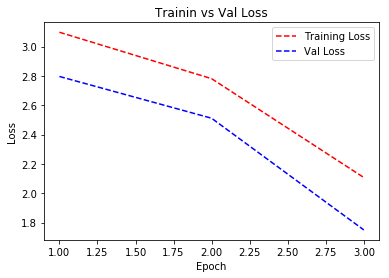

In [38]:
# Plot training vs val loss
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_losses, 'r--')
plt.plot(epoch_range, val_epoch_losses, 'b--')
plt.title('Trainin vs Val Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

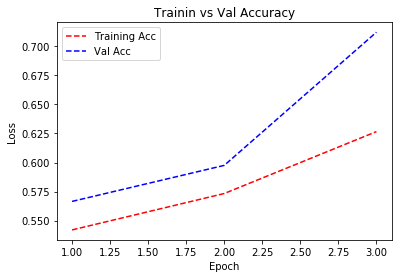

In [39]:
# Plot training vs val accuracy
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_accs, 'r--')
plt.plot(epoch_range, val_epoch_accs, 'b--')
plt.title('Trainin vs Val Accuracy')
plt.legend(['Training Acc', 'Val Acc'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Test prediction

In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(manager.latest_checkpoint)

In [41]:
rand = np.random.randint(0, len(train_inp_data))
test = train_inp_data[rand]
test = convert(input_tokenizer, test, send_back=True)
test = ' '.join(test)
test = test.replace('<s> ', '')
test = test.replace(' <e>', '')
print('Test Sequence: {}'.format(test))

Tokenized Data: [  2  29   7  12  33 261 312  11 354   9  63  57 495 121  43 119   7 159
 431  32 102 659 173 476  24  16  14 277 154  28   1   3   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Original Data: ['<s>', 'cung', 'co', 'mot', 'so', 'tranh', 'luan', 'trong', 'vong', 'cac', 'hoc', 'gia', 'khang', 'cach', 've', 'viec', 'co', 'nen', 'ap', 'dung', 'giao', 'huan', 'tan', 'uoc', 'cho', 'nguoi', 'do', 'thai', 'hay', 'khong', '.', '<e>']
Test Sequence: cung co mot so tranh luan trong vong cac hoc gia khang cach ve viec co nen ap dung giao huan tan uoc cho nguoi do thai hay khong .


Tokenized Data: [   2   41   10   11   31  246  377   12  649    8   43  385  811   71
   35   69   10  185  597   83   78 1339  639  601   18   14   79  276
  106   19    1    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


Original Data: ['<s>', 'cũng', 'có', 'một', 'số', 'tranh', 'luận', 'trong', 'vòng', 'các', 'học', 'giả', 'kháng', 'cách', 'về', 'việc', 'có', 'nên', 'áp', 'dụng', 'giáo', 'huấn', 'tân', 'ước', 'cho', 'người', 'do', 'thái', 'hay', 'không', '.', '<e>']
Original: <s> cũng có một số tranh luận trong vòng các học giả kháng cách về việc có nên áp dụng giáo huấn tân ước cho người do thái hay không . <e>
Input: cung co mot so tranh luan trong vong cac hoc gia khang cach ve viec co nen ap dung giao huan tan uoc cho nguoi do thai hay khong .
Predicted translation: một số số các chương các học gia đình này trong những người . <e> 


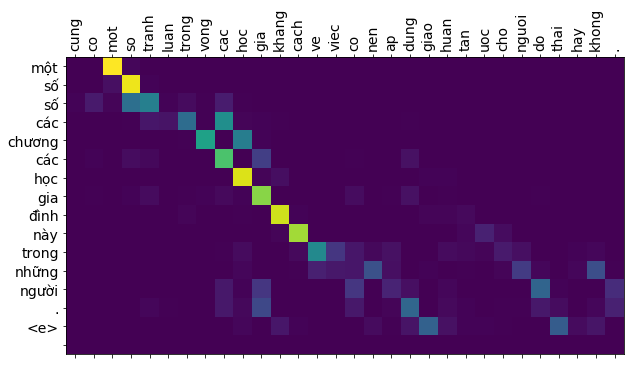

In [42]:
test_tar = convert(target_tokenizer, train_tar_data[rand], send_back=True)
test_tar = ' '.join(test_tar)
print('Original: {}'.format(test_tar))
restore(test)